# Homogenous 1D Elastic Wave Equation 

In order to explote finite volume solvers we seek to investigate the 1-D elastic wave equation propogating through a homogenous medium. The source free elastic wave equation can be written a coupled sytems of equation 
$$
\begin{gather*}
    \frac{\partial}{\partial t} \sigma - \mu \frac{\partial}{\partial x} v = 0  \\
     \frac{\partial}{\partial t} v - \frac{1}{\rho} \frac{\partial}{\partial x} \sigma = 0 
\end{gather*}
$$
where $\sigma = \sigma_{xy}(x,t)$ is the shear stress component of the stress tensor, $v = v_y(x,t)$ is the transerve velocity, $\rho$ is the density and $\mu$ is the bulk modulus. In matrix vector notation the equation becomes 
$$
\begin{gather*}
    \partial_t \begin{bmatrix} \sigma \\ v \end{bmatrix} + \begin{bmatrix} 0 & -\mu \\ -1/\rho & 0 \end{bmatrix} \partial_x \begin{bmatrix} \sigma \\ v \end{bmatrix} = 0
\end{gather*}
$$
which simplifies to 
$$
    \partial_t Q + A \partial_x Q = 0. 
$$
Our elastic wave eqaution above is analgous to the 1-D advection equation except our equations above are a couple system of equations. In order to make use  of the well documented numerical methods for the 1-D advection equation we must decouple this system. We seek to show that the equation is hyperbolic by demonstarting that $A$ is diagonalizable with real eigenvalues. We are looking for the eigenvalue decomposition of $A$ such that 
$$
\begin{equation*}
    A = X \Lambda X^{-1}\\
\end{equation*}
$$
By subbing in the the eigendecompostion of $A$ into our matrix vector form of our equation and multiplying both sides of the equation by $X^{-1}$ we get 
$$
\begin{equation*}
   X^{-1} \partial_t Q +X^{-1} X \Lambda X^{-1} \partial_x Q = 0. 
\end{equation*}
$$
where the $X^{-1}Q = W$ the solution vector. Simplying the equation 
$$
\begin{equation*}
   \partial_t W + \Lambda \partial_x W = 0. 
\end{equation*}
$$
we now have a decoupled equation which allows us to utilize the numerical methods derived for the advection equation. We find the eigenvalues of $A$ to be 
$$
\begin{align*}
    Ax &= \lambda x \\
    (A-\lambda I )x &= 0 \\
    \det\left|\begin{matrix} -\lambda & -\mu\\ -1/\rho & -\lambda\end{matrix} \right| &= 0\\
    \lambda & = \pm \sqrt{\mu/\rho} = \pm C
\end{align*}
$$
where $C$ is the shear stress velocity. Therefore the eigenvectors of $A$ are 
$$
\begin{align*}
    \begin{bmatrix} C & -\mu \\ -1/\rho & C \end{bmatrix} \begin{bmatrix} x_1 \\ x_2\end{bmatrix} = 0, && x_1 = \begin{bmatrix} \rho c \\ 1 \end{bmatrix}
\end{align*}
$$
and 
$$
\begin{align*}
    \begin{bmatrix} -C & -\mu \\ -1/\rho & -C \end{bmatrix} \begin{bmatrix} x_1 \\ x_2\end{bmatrix} = 0, && x_2 = \begin{bmatrix} -\rho c \\ 1 \end{bmatrix}.
\end{align*}
$$
Which now have our matrix of eigenvectors
$$
\begin{align*}
    X = \begin{bmatrix} pc & -pc \\ 1 & 1\end{bmatrix}
\end{align*}
$$
for which the inverse is 
$$
\begin{align*}
    X^{-1} = \frac{1}{2\rho c} \begin{bmatrix} 1 & pc \\ -1 & pc\end{bmatrix}
\end{align*}
$$
meaning we have a full eigendecompsotion of $A$ such that 
$$
\begin{align*}
    A = \begin{bmatrix} pc & -pc \\ 1 & 1 \end{bmatrix} \begin{bmatrix} -c & 0 \\ 0 & c \end{bmatrix} \frac{1}{2\rho c} \begin{bmatrix} 1 & pc \\ -1 & pc\end{bmatrix}
\end{align*}
$$

## Intializing and inital conditions 

We are using 
$$
\begin{equation}
    Q(x,0) = e^{-\beta (x-x_0)^2} \cos (\gamma (x-x_0))
\end{equation}
$$
as our intial condition. 

In [1]:
import numpy as np 
from scipy import linalg as LA 
import matplotlib.pyplot as plt 
from matplotlib import animation, rc
rc('animation', html='jshtml')

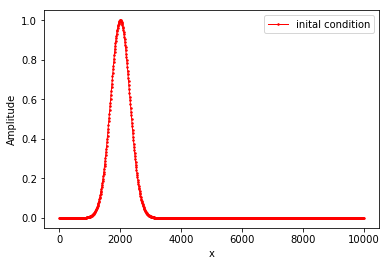

In [2]:
# Material Properties 
# -----------------------------------------------------
C   = 2500              # velcoity (m/s) 
rho = 2500              # density  (kg/m^3) 
Z   = rho*C             # impedance (kg/(s m^2))
mu  = rho*C**2          # bluk modulus 

# Model Domain 
# -----------------------------------------------------
nx  = 1000              # number of grid cells
L   = 10*1000           # domain length (m)
cfl = 0.5               # Counrant Number 
T   = 2                 # length of simulation (s)

# Inital Conditions
# -----------------------------------------------------
bet = 5e-6              # arugments in initial cond.
gam = 2e-5              # arugments in initial cond.
x0  = 2000              # postion of the initial conidition 

# Initalizing spatial domain 
x, dx = np.linspace(0,L,nx,retstep=True)

# CFL criterion to ensure convergence
dt  = cfl*dx/C              # calculate dt based on CFL criteron
nt  = int(np.floor(T/dt))   # nt from dt calculated

# Initalize solution matrix
Q_lwf = np.zeros((2,nx,nt)) # Lax-Wefford
Q_up  = np.zeros((2,nx,nt)) # Upwind
Q_a   = np.zeros((2,nx,nt)) # Analytical

# Inital condition
# -----------------------------------------------------
Q_lwf[0,:,0] = np.exp(-bet * (x-x0)**2) * np.cos(gam * (x - x0))
Q_up[0,:,0]  = np.exp(-bet * (x-x0)**2) * np.cos(gam * (x - x0))
Q_a[0,:,0]   = np.exp(-bet * (x-x0)**2) * np.cos(gam * (x - x0))

# Plot inital condition
# -----------------------------------------------------
plt.plot(x,  Q_lwf[0,:,0],'r-o', lw=1, markersize=1.5,  label="inital condition")
plt.ylabel('Amplitude')
plt.xlabel('x')
plt.legend()
#plt.savefig('./test.eps')

## Local Python Solutions 

We now decompose the solution into left and right propogating vectors as
$$
\begin{align*}
\Lambda^+ = \begin{bmatrix} -c & 0 \\ 0 & 0 \end{bmatrix}, && \Lambda^{-} = \begin{bmatrix} 0 & 0\\ 0 & c \end{bmatrix}, && A^{\pm} = X \Lambda^{\pm} X^{-1}
\end{align*}
$$

In [3]:
X    = np.array([[Z,-Z],[1,1]])             # Eigenvector Matrix
Xinv = 1/(2*Z) * np.array([[1,Z],[-1,Z]])   # Inverse of eigenvector Matrix
LamP = np.array([[ 0,0],[0,C]])             # Positive Lambda
LamM = np.array([[-C,0],[0,0]])             # Negative Lambda
AP   = X @ LamP @ Xinv                      # Postive decomposed A
AM   = X @ LamM @ Xinv                      # Negative decomposed A
A    = np.array([[0, -mu],[-1/rho,0]])      # Coefficent matrix A

### Upwind Method 

$$
\begin{equation}
      Q_j^{n+1} = Q_j^{n} - \frac{\Delta t}{\Delta x} \left[ A^{+} \Delta Q_l - A^{-} \Delta Q_r \right]
\end{equation}  
$$
with
$$
\begin{align*}
\Delta Q_l = Q^n_{j} - Q^n_{j-1} && \Delta Q_r = Q^n_{j+1} - Q^n_{j}
\end{align*}
$$
where 
$$
\begin{align*}
\mathcal{F}_i = A^{\pm} \Delta Q_{l,r}
\end{align*}
$$

In [4]:
nt * dt

2.0

In [5]:
# Upwind Method for 3D array 
# -----------------------------------------------------
for n in range(nt-1):
    for j in range(1,nx-1):  
        dQl = Q_up[:,j,n] - Q_up[:,j-1,n]
        dQr = Q_up[:,j+1,n] - Q_up[:,j,n]
        Q_up[:,j,n+1] = Q_up[:,j,n] - (dt/dx) * (AP.dot(dQl) + AM.dot(dQr)) 
        
    Q_up[:,0,n+1]  = Q_up[:,-2,n+1]
    Q_up[:,-1,n+1]  = Q_up[:,1,n+1]

In [6]:
fig, ax1 = plt.subplots(1,1, figsize=(10,6))

ax2 = ax1.twinx()


line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='r')
line = [line1, line2]

ax1.set_xlim((0, L))
ax2.set_xlim((0, L))

ax1.set_ylim((-1, 1.1))
ax2.set_ylim((-1e-7, 1.1e-7))

def animate(i):  
    global x,Q_up
    line[0].set_data(x, Q_up[0,:,i])
    line[1].set_data(x, Q_up[1,:,i])
    return line

anim = animation.FuncAnimation(fig, animate, 
                               frames=range(0,nt,10), interval=40, blit=True)
plt.close()
#anim

### Lax-Wefford 

A second order numerical method

$$
\begin{equation}
      Q_j^{n+1} = Q_j^{n} - \frac{\Delta t}{2 \Delta x} A \left[\Delta Q_{j+1} - \Delta Q_{j-1} \right] + \frac{1}{2} \left( \frac{\Delta t}{\Delta x}\right)^2 A^2 \left(Q_{j+1}^n - 2Q_j^n + Q^n_{j-1}\right)
\end{equation}  
$$

In [8]:
# Lax-Wendroff scheme 
# -----------------------------------------------------
for n in range(nt-1):
    for j in range(1,nx-1):  
        dQ1 = Q_lwf[:,j+1,n] - Q_lwf[:,j-1,n]
        dQ2 =Q_lwf[:,j+1,n] - 2*Q_lwf[:,j,n] + Q_lwf[:,j-1,n]
        Q_lwf[:,j,n+1] = Q_lwf[:,j,n] - 0.5*(dt/dx) * A.dot(dQ1) +\
                     0.5*(dt/dx)**2 * (A@A).dot(dQ2)
        
    Q_lwf[:,0,n+1]   = Q_lwf[:,-2,n+1]
    Q_lwf[:,-1,n+1]  = Q_lwf[:,1,n+1]

## PyClaw

In [9]:
from clawpack import pyclaw
from clawpack import riemann

claw = pyclaw.Controller()  # initialize pyClaw Solver
claw.tfinal = T             # set intergration time equal to as defined above

claw.keep_copy = True       # Keep solution data in memory for plotting
claw.output_format = None   # Don't write solution data to file
claw.num_output_times = nt  # Write 50 output frames

riemann_solver = riemann.acoustics_1D
claw.solver = pyclaw.ClawSolver1D(riemann_solver)
claw.solver.all_bcs = pyclaw.BC.periodic
claw.solver.limiters = pyclaw.limiters.tvd.superbee

domain = pyclaw.Domain( (0.,), (L,), (nx,))
claw.solution = pyclaw.Solution(claw.solver.num_eqn,domain)

x_claw =domain.grid.x.centers
claw.solution.q[0,:] = np.exp(-bet * (x_claw-x0)**2) * np.cos(gam * (x_claw - x0))
claw.solution.q[1,:] = 0.

claw.solution.state.problem_data = {
                              'rho' : -rho,
                              'bulk': -mu,
                              'zz'  : -Z,
                              'cc'  : C
                              }
status = claw.run()

2019-11-30 01:51:27,317 INFO CLAW: Solution 0 computed for time t=0.000000
2019-11-30 01:51:27,319 INFO CLAW: Solution 1 computed for time t=0.002002
2019-11-30 01:51:27,320 INFO CLAW: Solution 2 computed for time t=0.004004
2019-11-30 01:51:27,321 INFO CLAW: Solution 3 computed for time t=0.006006
2019-11-30 01:51:27,325 INFO CLAW: Solution 4 computed for time t=0.008008
2019-11-30 01:51:27,327 INFO CLAW: Solution 5 computed for time t=0.010010
2019-11-30 01:51:27,329 INFO CLAW: Solution 6 computed for time t=0.012012
2019-11-30 01:51:27,331 INFO CLAW: Solution 7 computed for time t=0.014014
2019-11-30 01:51:27,333 INFO CLAW: Solution 8 computed for time t=0.016016
2019-11-30 01:51:27,335 INFO CLAW: Solution 9 computed for time t=0.018018
2019-11-30 01:51:27,338 INFO CLAW: Solution 10 computed for time t=0.020020
2019-11-30 01:51:27,349 INFO CLAW: Solution 11 computed for time t=0.022022
2019-11-30 01:51:27,351 INFO CLAW: Solution 12 computed for time t=0.024024
2019-11-30 01:51:27,35

In [10]:
fig, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.set_xlim(0, L) ; ax1.set_ylim(-0.8, 1.2)
ax2 = ax1.twinx()
ax2.set_xlim(0, L) ; ax2.set_ylim(-0.8e-7, 1.2e-7)

frame = claw.frames[0]
pressure = frame.q[0,:]
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], 'r', lw=2)
line = [line1, line2]

plt.legend(['p','u'])

def fplot(frame_number):
    frame = claw.frames[frame_number]
    pressure = frame.q[0,:]
    velocity = frame.q[1,:]
    line[0].set_data(x_claw,pressure)
    line[1].set_data(x_claw,velocity)
    return line

anim = animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=40, repeat=False)
plt.close()
#anim

## Analytical Solution 
$$
\begin{equation}
\begin{gathered}
    \sigma(x,t) = \frac{1}{2} (\sigma^0(x+Ct) + \sigma^0(x-Ct)) + \frac{Z}{2} (v^0(x+Ct) - v^0(x-Ct)) \\ 
    v(x,t) = \frac{1}{2Z}(\sigma^0(x+Ct) - \sigma^0(x-Ct)) + \frac{1}{2}(v^0(x+Ct) + v^0(x-Ct)).
    \label{eq:analsolution}
\end{gathered}
\end{equation}
$$


$$
\begin{equation}
    \sigma(x,0) = e^{-\beta (x-x_0)^2} \cos (\gamma (x-x_0))
\end{equation}
$$

In [46]:
for n in range(nt):
    Q_a[0,1:-1,n] = (1./2.)*(np.exp(-bet * (x[1:-1]-x0 + C*n*dt)**2)*np.cos(gam*(x[1:-1]-x0 + C*n*dt))\
        + np.exp(-bet * (x[1:-1]-x0 - C*n*dt)**2)*np.cos(gam*(x[1:-1]-x0 - C*n*dt)))
    
    Q_a[1,1:-1,n] = (1./(2*Z))*(np.exp(-bet * (x[1:-1]-x0 + C*n*dt)**2)*np.cos(gam*(x[1:-1]-x0 + C*n*dt))\
        - np.exp(-bet * (x[1:-1]-x0 - C*n*dt)**2)*np.cos(gam*(x[1:-1]-x0 - C*n*dt)))

    Q_a[:,0,n]   = Q_a[:,-2,n]
    Q_a[:,-1,n]  = Q_a[:,1,n]
    

# Intercomparision of method

In [47]:
fig, ax = plt.subplots(2,1,figsize=(15,8))

ax[0].set_xlim(0, L)
ax[0].set_ylim(-0.8, 1.2)

ax[1].set_xlim(0, L)
ax[1].set_ylim(-0.9e-7, 1.2e-7)

ax[0].set_ylabel('Stress')
ax[1].set_ylabel('Velocity')
ax[1].set_xlabel(' x ')

line1, = ax[0].plot([], [], lw=2, color='lightblue',label='Upwind')
line2, = ax[1].plot([], [], lw=2, color='lightblue')
line3, = ax[0].plot([], [], lw=2, color='k',ls=':',label='Lax-Wefford')
line4, = ax[1].plot([], [], lw=2, color='k',ls=':')
line5, = ax[0].plot([], [], lw=2, color='r',ls='--',label='PyClaw')
line6, = ax[1].plot([], [], lw=2, color='r',ls='--')
line7, = ax[0].plot([], [], lw=1, color='g',ls='--',label='Analytical')
line8, = ax[1].plot([], [], lw=1, color='g',ls='--')
line = [line1, line2,line3,line4,line5,line6,line7,line8]
ax[0].legend()

def animate(i):  
    global x,Q_lwf,Q_up,Q_a
    
    frame = claw.frames[i]
    pressure = frame.q[0,:]
    velocity = frame.q[1,:]
    
    line[0].set_data(x, Q_up[0,:,i])
    line[1].set_data(x, Q_up[1,:,i])
    line[2].set_data(x, Q_lwf[0,:,i])
    line[3].set_data(x, Q_lwf[1,:,i])
    line[4].set_data(x_claw,pressure)
    line[5].set_data(x_claw,velocity)
    line[6].set_data(x, Q_a[0,:,i])
    line[7].set_data(x, Q_a[1,:,i])
    return line

anim = animation.FuncAnimation(fig, animate, 
                               frames=range(0,nt,10), interval=40, blit=True)
plt.close()
anim